In [1]:
from processed_image import ProcessedImage, read_from_dir, show_image_strip
imgs = list(read_from_dir('..\\Data\\LittleCarDb1'))
[str(img) for img in imgs[0:5]]

['ProcessedImage for ..\\Data\\LittleCarDb1\\SF0836-001_1.jpg (0 in cache)',
 'ProcessedImage for ..\\Data\\LittleCarDb1\\SF0836-002_1.jpg (0 in cache)',
 'ProcessedImage for ..\\Data\\LittleCarDb1\\SF0836-005_1.jpg (0 in cache)',
 'ProcessedImage for ..\\Data\\LittleCarDb1\\SF0836-007_1.jpg (0 in cache)',
 'ProcessedImage for ..\\Data\\LittleCarDb1\\SF0836-008_1.jpg (0 in cache)']

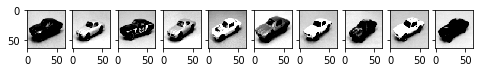

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
_, axes = plt.subplots(1, 10, sharey=True, figsize=(8,1.5))
show_image_strip(imgs, axes)

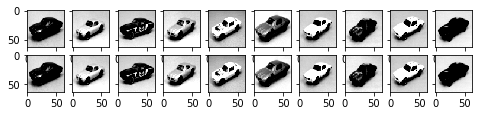

In [4]:
_, axes = plt.subplots(2, 10, sharey=True, figsize=(8,1.5))
processed_dict = {img.fullpath:img.get_processed_image() for img in imgs}
show_image_strip(imgs, axes, predicted_dict=processed_dict)

In [5]:
import numpy as np
x_train = [img.get_processed_image() for img in imgs]
x_train = np.array(x_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], x_train.shape[2], 1))

In [6]:
# x_train_proc = \
# [np.clip(0.5 + (img - img.mean()) / (2.0*img.std()), 0.0, 1.0) for img in x_train]
# x_train_proc = np.array(x_train_proc)
x_train_proc = x_train
x_train[0].shape, x_train_proc[0].shape

((64, 64, 1), (64, 64, 1))

In [7]:
from keras.layers import Dense, Input, SpatialDropout2D
from keras.layers import Conv2D, Flatten, Lambda
from keras.layers import LocallyConnected2D, ZeroPadding2D
from keras.layers import MaxPooling2D, UpSampling2D
from keras.layers import Reshape, Conv2DTranspose
from keras.layers import ActivityRegularization
from keras.models import Model
from keras.datasets import mnist
from keras.losses import mse, binary_crossentropy
from keras.utils import plot_model
from keras import backend as K

Using TensorFlow backend.


In [8]:
# reparameterization trick
# instead of sampling from Q(z|X), sample eps = N(0,I)
# then z = z_mean + sqrt(var)*eps
def sampling(args):
    """Reparameterization trick by sampling fr an isotropic unit Gaussian.

    # Arguments
        args (tensor): mean and log of variance of Q(z|X)

    # Returns
        z (tensor): sampled latent vector
    """

    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean=0 and std=1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

In [18]:
from model_vae_3stage import build_encoded_layer

def build_autoencoder(sz, optimizer, loss):
    encoded_layer, input_img = build_encoded_layer(sz, in_channels=1)
    
    # shape info needed to build decoder model
    shape = K.int_shape(encoded_layer)

    # generate latent vector Q(z|X)
    latent_dim = 8
    x = Flatten()(encoded_layer)
    x = Dense(32, activation='relu')(x)
    z_mean = Dense(latent_dim, name='z_mean')(x)
    z_log_var = Dense(latent_dim, name='z_log_var')(x)

    # use reparameterization trick to push the sampling out as input
    # note that "output_shape" isn't necessary with the TensorFlow backend
    z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])


    encoder = Model(input_img, [z_mean, z_log_var, z], name='encoder')
    encoder.summary()
    # plot_model(encoder, to_file='data\dicom_encoder.png', show_shapes=True)

    # TODO: add threshold layer for sparsity test



    # build decoder model
    latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
    x = Dense(shape[1] * shape[2] * shape[3], activation='relu')(latent_inputs)
    x = Reshape((shape[1], shape[2], shape[3]))(x)

    x = LocallyConnected2D(32, (3,3))(x)
    x = ZeroPadding2D(padding=(1,1))(x)
    x = UpSampling2D((2,2))(x)
    x = Conv2DTranspose(32, (3,3), activation='relu', padding='same')(x)
    x = UpSampling2D((2,2))(x)
    x = Conv2DTranspose(32, (3,3), activation='relu', padding='same')(x)
    x = UpSampling2D((2,2))(x)
    x = Conv2DTranspose(32, (3,3), activation='relu', padding='same')(x)
    x = UpSampling2D((2,2))(x)
    decoded_layer = Conv2D(1, (3,3), activation='sigmoid', padding='same')(x)
    decoder = Model(latent_inputs, decoded_layer)
    decoder.summary()
    # plot_model(decoder, to_file='data\dicom_decoder.png', show_shapes=True)

    autoencoder_output = decoder(encoder(input_img)[2])
    autoencoder = Model(input_img, autoencoder_output, name='ae')
    autoencoder.compile(optimizer=optimizer, loss=loss)
    autoencoder.summary()
    # plot_model(autoencoder, to_file='data\dicom_autoencoder.png', show_shapes=True)

    return autoencoder, encoder, decoder

In [19]:
vae, enc, dec = build_autoencoder(64, 'adadelta', 
                                      # 'categorical_crossentropy')
                                      'mean_squared_error')
                                      # 'binary_crossentropy')

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 64, 64, 1)    0                                            
__________________________________________________________________________________________________
conv2d_5 (Conv2D)               (None, 64, 64, 32)   320         input_2[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_5 (MaxPooling2D)  (None, 32, 32, 32)   0           conv2d_5[0][0]                   
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, 32, 32, 32)   9248        max_pooling2d_5[0][0]            
__________________________________________________________________________________________________
max_poolin

In [20]:
import random
x_test = np.array(random.sample(list(x_train_proc), int(len(x_train_proc)/10)))
x_train_proc.shape, x_test.shape

((171, 64, 64, 1), (17, 64, 64, 1))

In [21]:
vae.fit(x_train_proc, x_train_proc, epochs=1000, batch_size=1024, 
        shuffle=True, validation_data=(x_test,x_test))

Train on 171 samples, validate on 17 samples
Epoch 1/1000
171/171 [==============================] - 2s 9ms/step - loss: 0.1388 - val_loss: 0.1543
Epoch 2/1000
171/171 [==============================] - 0s 357us/step - loss: 0.1385 - val_loss: 0.1536
Epoch 3/1000
171/171 [==============================] - 0s 339us/step - loss: 0.1379 - val_loss: 0.1529
Epoch 4/1000
171/171 [==============================] - 0s 339us/step - loss: 0.1374 - val_loss: 0.1521
Epoch 5/1000
171/171 [==============================] - 0s 333us/step - loss: 0.1368 - val_loss: 0.1513
Epoch 6/1000
171/171 [==============================] - 0s 339us/step - loss: 0.1361 - val_loss: 0.1504
Epoch 7/1000
171/171 [==============================] - 0s 339us/step - loss: 0.1354 - val_loss: 0.1493
Epoch 8/1000
171/171 [==============================] - 0s 339us/step - loss: 0.1346 - val_loss: 0.1482
Epoch 9/1000
171/171 [==============================] - 0s 333us/step - loss: 0.1336 - val_loss: 0.1471
Epoch 10/1000
171/171

Epoch 79/1000
171/171 [==============================] - 0s 333us/step - loss: 0.0714 - val_loss: 0.0617
Epoch 80/1000
171/171 [==============================] - 0s 333us/step - loss: 0.0728 - val_loss: 0.0656
Epoch 81/1000
171/171 [==============================] - 0s 316us/step - loss: 0.0721 - val_loss: 0.0631
Epoch 82/1000
171/171 [==============================] - 0s 333us/step - loss: 0.0737 - val_loss: 0.0718
Epoch 83/1000
171/171 [==============================] - 0s 322us/step - loss: 0.0731 - val_loss: 0.0616
Epoch 84/1000
171/171 [==============================] - 0s 327us/step - loss: 0.0739 - val_loss: 0.0695
Epoch 85/1000
171/171 [==============================] - 0s 339us/step - loss: 0.0726 - val_loss: 0.0623
Epoch 86/1000
171/171 [==============================] - 0s 322us/step - loss: 0.0729 - val_loss: 0.0677
Epoch 87/1000
171/171 [==============================] - 0s 322us/step - loss: 0.0732 - val_loss: 0.0606
Epoch 88/1000
171/171 [==============================] 

Epoch 157/1000
171/171 [==============================] - 0s 327us/step - loss: 0.0692 - val_loss: 0.0596
Epoch 158/1000
171/171 [==============================] - 0s 316us/step - loss: 0.0691 - val_loss: 0.0615
Epoch 159/1000
171/171 [==============================] - 0s 322us/step - loss: 0.0688 - val_loss: 0.0589
Epoch 160/1000
171/171 [==============================] - 0s 322us/step - loss: 0.0683 - val_loss: 0.0606
Epoch 161/1000
171/171 [==============================] - 0s 327us/step - loss: 0.0687 - val_loss: 0.0582
Epoch 162/1000
171/171 [==============================] - 0s 333us/step - loss: 0.0682 - val_loss: 0.0621
Epoch 163/1000
171/171 [==============================] - 0s 328us/step - loss: 0.0689 - val_loss: 0.0572
Epoch 164/1000
171/171 [==============================] - 0s 327us/step - loss: 0.0679 - val_loss: 0.0622
Epoch 165/1000
171/171 [==============================] - 0s 339us/step - loss: 0.0677 - val_loss: 0.0556
Epoch 166/1000
171/171 [======================

Epoch 235/1000
171/171 [==============================] - 0s 322us/step - loss: 0.0509 - val_loss: 0.0417
Epoch 236/1000
171/171 [==============================] - 0s 316us/step - loss: 0.0504 - val_loss: 0.0445
Epoch 237/1000
171/171 [==============================] - 0s 322us/step - loss: 0.0502 - val_loss: 0.0420
Epoch 238/1000
171/171 [==============================] - 0s 333us/step - loss: 0.0500 - val_loss: 0.0440
Epoch 239/1000
171/171 [==============================] - 0s 345us/step - loss: 0.0501 - val_loss: 0.0423
Epoch 240/1000
171/171 [==============================] - 0s 339us/step - loss: 0.0499 - val_loss: 0.0456
Epoch 241/1000
171/171 [==============================] - 0s 327us/step - loss: 0.0500 - val_loss: 0.0417
Epoch 242/1000
171/171 [==============================] - 0s 327us/step - loss: 0.0501 - val_loss: 0.0454
Epoch 243/1000
171/171 [==============================] - 0s 322us/step - loss: 0.0506 - val_loss: 0.0438
Epoch 244/1000
171/171 [======================

Epoch 313/1000
171/171 [==============================] - 0s 333us/step - loss: 0.0499 - val_loss: 0.0437
Epoch 314/1000
171/171 [==============================] - 0s 322us/step - loss: 0.0495 - val_loss: 0.0431
Epoch 315/1000
171/171 [==============================] - 0s 327us/step - loss: 0.0482 - val_loss: 0.0414
Epoch 316/1000
171/171 [==============================] - 0s 327us/step - loss: 0.0473 - val_loss: 0.0417
Epoch 317/1000
171/171 [==============================] - 0s 327us/step - loss: 0.0468 - val_loss: 0.0403
Epoch 318/1000
171/171 [==============================] - 0s 327us/step - loss: 0.0462 - val_loss: 0.0405
Epoch 319/1000
171/171 [==============================] - 0s 327us/step - loss: 0.0461 - val_loss: 0.0401
Epoch 320/1000
171/171 [==============================] - 0s 327us/step - loss: 0.0460 - val_loss: 0.0406
Epoch 321/1000
171/171 [==============================] - 0s 327us/step - loss: 0.0459 - val_loss: 0.0396
Epoch 322/1000
171/171 [======================

Epoch 391/1000
171/171 [==============================] - 0s 333us/step - loss: 0.0449 - val_loss: 0.0376
Epoch 392/1000
171/171 [==============================] - 0s 339us/step - loss: 0.0454 - val_loss: 0.0405
Epoch 393/1000
171/171 [==============================] - 0s 327us/step - loss: 0.0451 - val_loss: 0.0381
Epoch 394/1000
171/171 [==============================] - 0s 333us/step - loss: 0.0459 - val_loss: 0.0410
Epoch 395/1000
171/171 [==============================] - 0s 327us/step - loss: 0.0457 - val_loss: 0.0394
Epoch 396/1000
171/171 [==============================] - 0s 345us/step - loss: 0.0464 - val_loss: 0.0416
Epoch 397/1000
171/171 [==============================] - 0s 327us/step - loss: 0.0465 - val_loss: 0.0415
Epoch 398/1000
171/171 [==============================] - 0s 339us/step - loss: 0.0473 - val_loss: 0.0419
Epoch 399/1000
171/171 [==============================] - 0s 339us/step - loss: 0.0475 - val_loss: 0.0433
Epoch 400/1000
171/171 [======================

Epoch 469/1000
171/171 [==============================] - 0s 333us/step - loss: 0.0438 - val_loss: 0.0393
Epoch 470/1000
171/171 [==============================] - 0s 333us/step - loss: 0.0436 - val_loss: 0.0374
Epoch 471/1000
171/171 [==============================] - 0s 345us/step - loss: 0.0440 - val_loss: 0.0393
Epoch 472/1000
171/171 [==============================] - 0s 333us/step - loss: 0.0436 - val_loss: 0.0369
Epoch 473/1000
171/171 [==============================] - 0s 339us/step - loss: 0.0441 - val_loss: 0.0394
Epoch 474/1000
171/171 [==============================] - 0s 327us/step - loss: 0.0437 - val_loss: 0.0369
Epoch 475/1000
171/171 [==============================] - 0s 327us/step - loss: 0.0442 - val_loss: 0.0401
Epoch 476/1000
171/171 [==============================] - 0s 333us/step - loss: 0.0435 - val_loss: 0.0368
Epoch 477/1000
171/171 [==============================] - 0s 328us/step - loss: 0.0442 - val_loss: 0.0402
Epoch 478/1000
171/171 [======================

Epoch 547/1000
171/171 [==============================] - 0s 322us/step - loss: 0.0472 - val_loss: 0.0426
Epoch 548/1000
171/171 [==============================] - 0s 327us/step - loss: 0.0446 - val_loss: 0.0379
Epoch 549/1000
171/171 [==============================] - 0s 327us/step - loss: 0.0455 - val_loss: 0.0410
Epoch 550/1000
171/171 [==============================] - 0s 316us/step - loss: 0.0429 - val_loss: 0.0358
Epoch 551/1000
171/171 [==============================] - 0s 316us/step - loss: 0.0426 - val_loss: 0.0391
Epoch 552/1000
171/171 [==============================] - 0s 333us/step - loss: 0.0419 - val_loss: 0.0354
Epoch 553/1000
171/171 [==============================] - 0s 316us/step - loss: 0.0416 - val_loss: 0.0387
Epoch 554/1000
171/171 [==============================] - 0s 322us/step - loss: 0.0416 - val_loss: 0.0359
Epoch 555/1000
171/171 [==============================] - 0s 322us/step - loss: 0.0419 - val_loss: 0.0391
Epoch 556/1000
171/171 [======================

Epoch 625/1000
171/171 [==============================] - 0s 327us/step - loss: 0.0407 - val_loss: 0.0369
Epoch 626/1000
171/171 [==============================] - 0s 333us/step - loss: 0.0401 - val_loss: 0.0352
Epoch 627/1000
171/171 [==============================] - 0s 327us/step - loss: 0.0405 - val_loss: 0.0365
Epoch 628/1000
171/171 [==============================] - 0s 322us/step - loss: 0.0398 - val_loss: 0.0347
Epoch 629/1000
171/171 [==============================] - 0s 322us/step - loss: 0.0399 - val_loss: 0.0361
Epoch 630/1000
171/171 [==============================] - 0s 327us/step - loss: 0.0394 - val_loss: 0.0348
Epoch 631/1000
171/171 [==============================] - 0s 328us/step - loss: 0.0396 - val_loss: 0.0357
Epoch 632/1000
171/171 [==============================] - 0s 327us/step - loss: 0.0392 - val_loss: 0.0349
Epoch 633/1000
171/171 [==============================] - 0s 322us/step - loss: 0.0395 - val_loss: 0.0361
Epoch 634/1000
171/171 [======================

Epoch 703/1000
171/171 [==============================] - 0s 374us/step - loss: 0.0401 - val_loss: 0.0378
Epoch 704/1000
171/171 [==============================] - 0s 392us/step - loss: 0.0395 - val_loss: 0.0340
Epoch 705/1000
171/171 [==============================] - 0s 386us/step - loss: 0.0398 - val_loss: 0.0372
Epoch 706/1000
171/171 [==============================] - 0s 368us/step - loss: 0.0393 - val_loss: 0.0335
Epoch 707/1000
171/171 [==============================] - 0s 345us/step - loss: 0.0394 - val_loss: 0.0370
Epoch 708/1000
171/171 [==============================] - 0s 327us/step - loss: 0.0390 - val_loss: 0.0339
Epoch 709/1000
171/171 [==============================] - 0s 333us/step - loss: 0.0394 - val_loss: 0.0367
Epoch 710/1000
171/171 [==============================] - 0s 351us/step - loss: 0.0390 - val_loss: 0.0342
Epoch 711/1000
171/171 [==============================] - 0s 351us/step - loss: 0.0397 - val_loss: 0.0369
Epoch 712/1000
171/171 [======================

Epoch 781/1000
171/171 [==============================] - 0s 327us/step - loss: 0.0383 - val_loss: 0.0349
Epoch 782/1000
171/171 [==============================] - 0s 351us/step - loss: 0.0386 - val_loss: 0.0363
Epoch 783/1000
171/171 [==============================] - 0s 339us/step - loss: 0.0389 - val_loss: 0.0362
Epoch 784/1000
171/171 [==============================] - 0s 322us/step - loss: 0.0405 - val_loss: 0.0374
Epoch 785/1000
171/171 [==============================] - 0s 339us/step - loss: 0.0394 - val_loss: 0.0362
Epoch 786/1000
171/171 [==============================] - 0s 334us/step - loss: 0.0411 - val_loss: 0.0363
Epoch 787/1000
171/171 [==============================] - 0s 333us/step - loss: 0.0384 - val_loss: 0.0340
Epoch 788/1000
171/171 [==============================] - 0s 327us/step - loss: 0.0386 - val_loss: 0.0354
Epoch 789/1000
171/171 [==============================] - 0s 322us/step - loss: 0.0377 - val_loss: 0.0330
Epoch 790/1000
171/171 [======================

Epoch 859/1000
171/171 [==============================] - 0s 322us/step - loss: 0.0366 - val_loss: 0.0339
Epoch 860/1000
171/171 [==============================] - 0s 322us/step - loss: 0.0365 - val_loss: 0.0326
Epoch 861/1000
171/171 [==============================] - 0s 327us/step - loss: 0.0367 - val_loss: 0.0344
Epoch 862/1000
171/171 [==============================] - 0s 339us/step - loss: 0.0368 - val_loss: 0.0328
Epoch 863/1000
171/171 [==============================] - 0s 327us/step - loss: 0.0370 - val_loss: 0.0344
Epoch 864/1000
171/171 [==============================] - 0s 328us/step - loss: 0.0370 - val_loss: 0.0326
Epoch 865/1000
171/171 [==============================] - 0s 327us/step - loss: 0.0370 - val_loss: 0.0341
Epoch 866/1000
171/171 [==============================] - 0s 333us/step - loss: 0.0369 - val_loss: 0.0325
Epoch 867/1000
171/171 [==============================] - 0s 339us/step - loss: 0.0371 - val_loss: 0.0338
Epoch 868/1000
171/171 [======================

Epoch 937/1000
171/171 [==============================] - 0s 327us/step - loss: 0.0361 - val_loss: 0.0330
Epoch 938/1000
171/171 [==============================] - 0s 333us/step - loss: 0.0362 - val_loss: 0.0329
Epoch 939/1000
171/171 [==============================] - 0s 333us/step - loss: 0.0361 - val_loss: 0.0328
Epoch 940/1000
171/171 [==============================] - 0s 333us/step - loss: 0.0362 - val_loss: 0.0326
Epoch 941/1000
171/171 [==============================] - 0s 333us/step - loss: 0.0359 - val_loss: 0.0324
Epoch 942/1000
171/171 [==============================] - 0s 339us/step - loss: 0.0359 - val_loss: 0.0320
Epoch 943/1000
171/171 [==============================] - 0s 333us/step - loss: 0.0357 - val_loss: 0.0325
Epoch 944/1000
171/171 [==============================] - 0s 328us/step - loss: 0.0357 - val_loss: 0.0317
Epoch 945/1000
171/171 [==============================] - 0s 339us/step - loss: 0.0361 - val_loss: 0.0337
Epoch 946/1000
171/171 [======================

(17, 64, 64, 1) -> (17, 8) -> (17, 64, 64, 1)


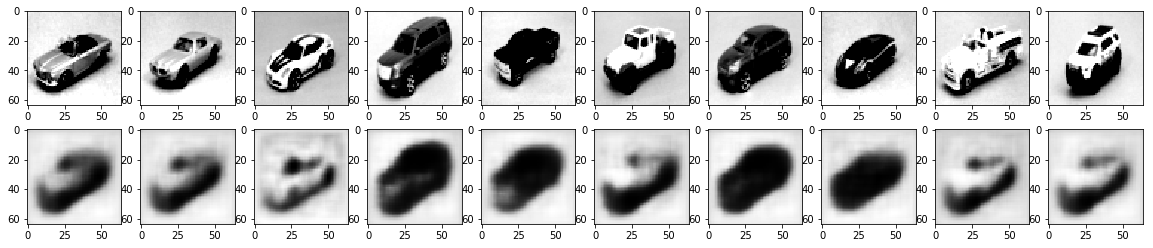

In [22]:
encoded_latent = enc.predict(x_test)[2]   # z parameter is #2
decoded_imgs = dec.predict(encoded_latent)
print(x_test.shape, '->', encoded_latent.shape, '->', decoded_imgs.shape)

def show_original_decoded(original, decoded, sz):
    n = 10  # how many digits we will display
    plt.figure(figsize=(n*2, 4))
    for i in range(n):
        ax = plt.subplot(2, n, i+1)
        # plt.imshow(colors.hsv_to_rgb(original[i].reshape(128, 128, 3)))     
        # re_original = original[i].reshape(128,128)
        plt.imshow(original[i].reshape(64, 64), cmap='gray')
        ax = plt.subplot(2, n, i+1+n)
        plt.imshow(decoded[i].reshape(64, 64), cmap='gray')
        # plt.imshow(colors.hsv_to_rgb
        # (decoded[i].reshape(128, 128, 3)))
        # plt.imshow(colors.hsv_to_rgb(decode_this_image))
    plt.show() # block=True)
# decoded_imgs = vae.predict(x_test)
show_original_decoded(x_test, decoded_imgs, 128)

In [ ]:
np.zeros((1,2,3,2))[:,:,:,1].std()